# Unsupervised Clustering on Eventfulness Vector Data

This notebook implements unsupervised clustering algorithms to analyze and cluster eventfulness vector data from the Excel file.


# Opening and Analyzing Excel Data

This notebook opens and analyzes the data from `peak_frames_data2.xlsx`


In [2]:
# Check and install necessary packages
import sys
import subprocess

required_packages = {
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'numpy': 'numpy',
    'openpyxl': 'openpyxl', 
    'xlrd': 'xlrd',
    'seaborn': 'seaborn',
    'sklearn': 'sklearn',
    'ast': 'ast',
    'mediapipe': 'mediapipe',
    'cv2': 'opencv-python'
}

def install_if_missing(package_name, import_name):
    try:
        __import__(import_name)
        print(f"✓ {package_name} is already installed")
    except ImportError:
        print(f"Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"✓ {package_name} has been installed")

for import_name, package_name in required_packages.items():
    install_if_missing(package_name, import_name)



✓ pandas is already installed
✓ matplotlib is already installed
✓ numpy is already installed
✓ openpyxl is already installed
✓ xlrd is already installed
✓ seaborn is already installed
✓ sklearn is already installed
✓ ast is already installed
✓ mediapipe is already installed
✓ opencv-python is already installed


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import ast
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')


In [4]:
# File path
excel_file = '/home/is1893/Mirror2/peak_frames_data2.xlsx'

# Add error handling for file loading
try:
    # Check if file exists
    if not os.path.exists(excel_file):
        raise FileNotFoundError(f"Excel file not found at: {excel_file}")
    
    # Load the Excel file with engine specification
    if excel_file.endswith('.xlsx'):
        df = pd.read_excel(excel_file, engine='openpyxl')
    elif excel_file.endswith('.xls'):
        df = pd.read_excel(excel_file, engine='xlrd')
    else:
        df = pd.read_excel(excel_file)
    
    # Display the first few rows of the dataframe
    print("Excel file loaded successfully!")
    df.head()
    
except Exception as e:
    print(f"Error loading Excel file: {str(e)}")
    print("Please check if the file exists and if you have the necessary permissions.")


Excel file loaded successfully!


In [5]:
# Get basic information about the dataframe
try:
    print("DataFrame Info:")
    df.info()
    
    print("\nDataFrame Description:")
    df.describe()
except NameError:
    print("DataFrame 'df' is not defined. Please make sure the Excel file was loaded successfully.")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ans                  11 non-null     int64  
 1   index                11 non-null     int64  
 2   peak_index           11 non-null     int64  
 3   frame_number         11 non-null     int64  
 4   time                 11 non-null     float64
 5   peak_value           11 non-null     float64
 6   vector_magnitude     11 non-null     float64
 7   image_filename       11 non-null     object 
 8   eventfulness_vector  11 non-null     object 
dtypes: float64(3), int64(4), object(2)
memory usage: 920.0+ bytes

DataFrame Description:


In [6]:
# Check for missing values
try:
    print("Missing Values:")
    df.isnull().sum()
    
    # Additional check for blank values (empty strings)
    print("\nBlank Values (empty strings):")
    blank_values = {}
    for column in df.columns:
        if df[column].dtype == object:  # Only check string/object columns
            blank_values[column] = (df[column] == '').sum()
    print(pd.Series(blank_values))
except NameError:
    print("DataFrame 'df' is not defined. Please make sure the Excel file was loaded successfully.")


Missing Values:

Blank Values (empty strings):
image_filename         0
eventfulness_vector    0
dtype: int64


## Data Exploration

Below you can add more cells for specific analysis of the data


Using features: [5, 6, 7, 8]
Data scaled successfully
Applied PCA for visualization. Explained variance ratio: [0.62068077 0.33844243]


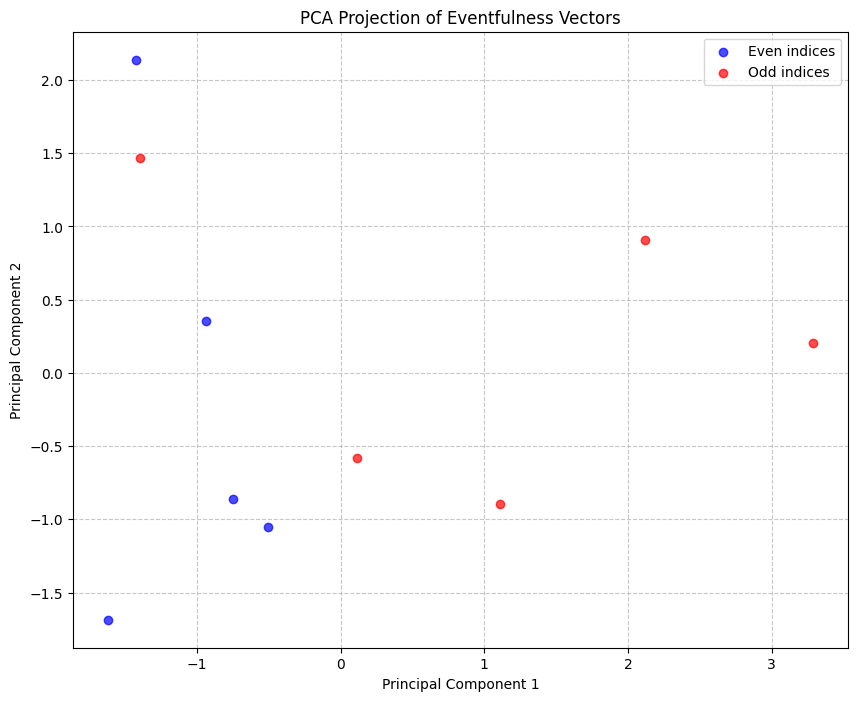

In [7]:
# Goal: create an unsupervised clustering model to cluster the eventfulness vectors, the expected output should be that even and odd indices are in different clusters

df['eventfulness_vector_parsed'] = df['eventfulness_vector'].apply(lambda x: np.array(ast.literal_eval(x)))

# Create a new DataFrame with the vectors expanded into separate columns
# This is necessary because sklearn expects a 2D array with each feature in a separate column
X = pd.DataFrame(df['eventfulness_vector_parsed'].tolist())
X = X.iloc[1:].reset_index(drop=True)

leftIndex = 5
rightIndex = leftIndex + 4
X = X.iloc[:, leftIndex:rightIndex] 
print(f"Using features: {list(X.columns)}")


# Preprocess the data
if X is not None:
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Data scaled successfully")
    
    # Apply PCA for visualization (if vector dimension > 2)
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        print(f"Applied PCA for visualization. Explained variance ratio: {pca.explained_variance_ratio_}")
        
        # Plot the PCA projection with different colors for odd and even indices
        plt.figure(figsize=(10, 8))
        
        # Create a boolean mask for even and odd indices
        even_mask = np.arange(len(X_pca)) % 2 == 0
        odd_mask = ~even_mask
        
        # Plot even indices in blue
        plt.scatter(X_pca[even_mask, 0], X_pca[even_mask, 1], alpha=0.7, color='blue', label='Even indices')
        # Plot odd indices in red
        plt.scatter(X_pca[odd_mask, 0], X_pca[odd_mask, 1], alpha=0.7, color='red', label='Odd indices')
        
        plt.title('PCA Projection of Eventfulness Vectors')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()
    else:
        X_pca = X_scaled
        print("No dimensionality reduction needed for visualization")


Silhouette Score: 0.3849
Clustering accuracy compared to even/odd indices: 0.8000


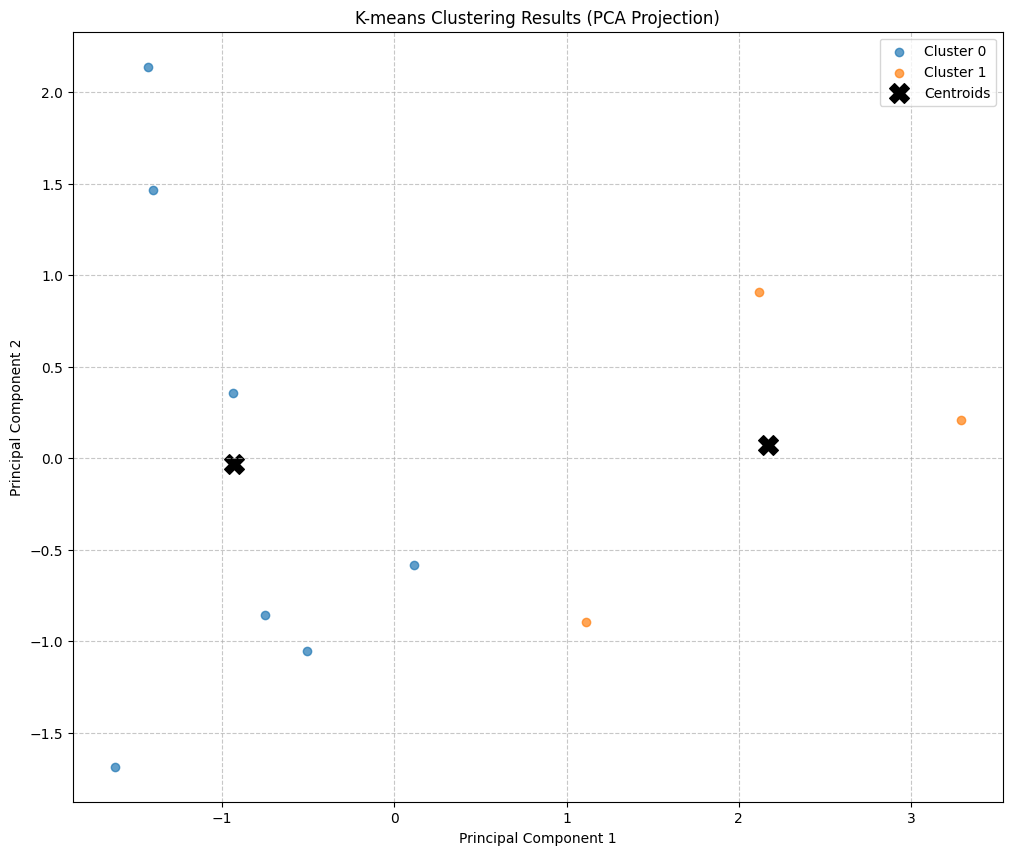

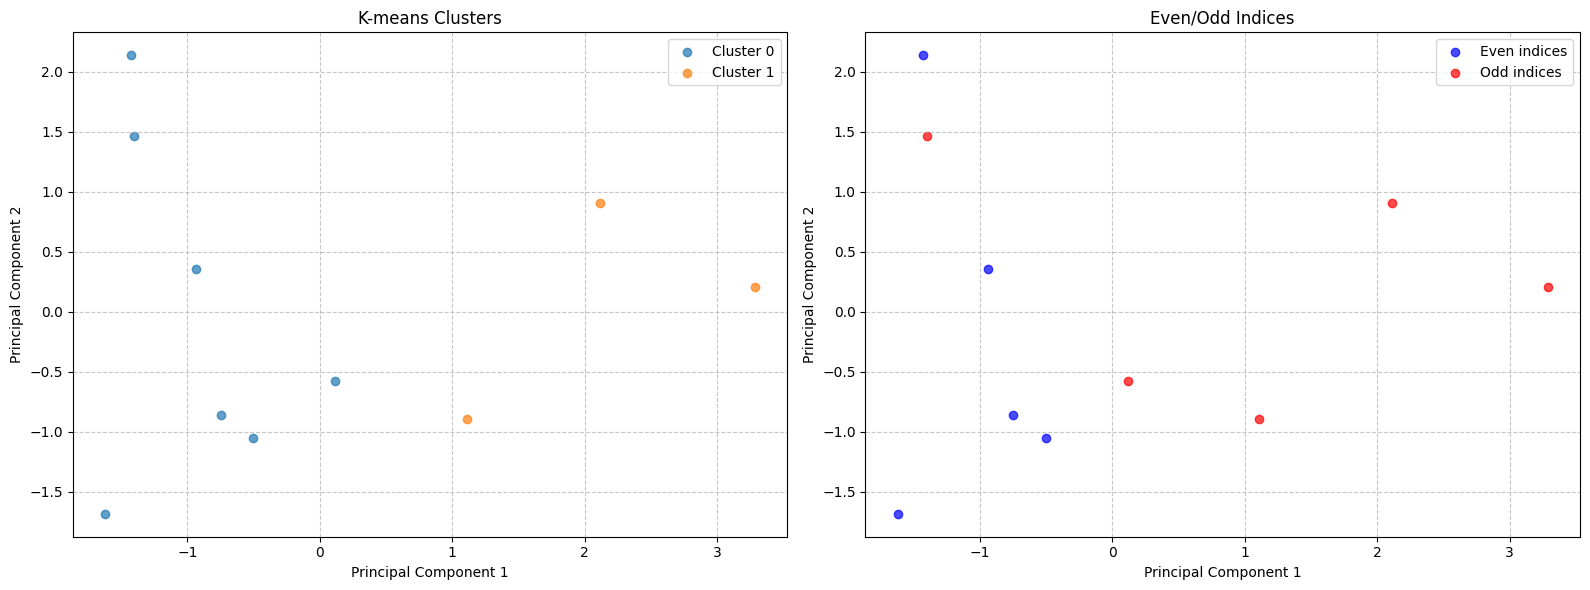

In [8]:
# Apply K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the number of clusters (2 for even/odd indices)
n_clusters = 2

# Initialize and fit K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Evaluate clustering performance
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Compare with expected even/odd grouping
expected_labels = np.arange(len(X_scaled)) % 2
# Handle potential label switching (0->1, 1->0)
accuracy1 = np.mean(cluster_labels == expected_labels)
accuracy2 = np.mean(cluster_labels != expected_labels)
accuracy = max(accuracy1, accuracy2)
print(f"Clustering accuracy compared to even/odd indices: {accuracy:.4f}")

# Visualize the clustering results with PCA data
if X.shape[1] > 2:
    plt.figure(figsize=(12, 10))
    
    # Plot clusters
    for i in range(n_clusters):
        plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], 
                   alpha=0.7, label=f'Cluster {i}')
    
    # Plot cluster centers (transformed to PCA space)
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, marker='X', c='black', label='Centroids')
    
    plt.title('K-means Clustering Results (PCA Projection)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    # Plot comparison between K-means clusters and even/odd indices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # K-means clusters
    for i in range(n_clusters):
        ax1.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], 
                   alpha=0.7, label=f'Cluster {i}')
    ax1.set_title('K-means Clusters')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # Even/odd indices
    even_mask = np.arange(len(X_pca)) % 2 == 0
    odd_mask = ~even_mask
    ax2.scatter(X_pca[even_mask, 0], X_pca[even_mask, 1], alpha=0.7, color='blue', label='Even indices')
    ax2.scatter(X_pca[odd_mask, 0], X_pca[odd_mask, 1], alpha=0.7, color='red', label='Odd indices')
    ax2.set_title('Even/Odd Indices')
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Human Pose Estimation Comparison
Path: /home/is1893/Mirror2/pose-photos

In [9]:
import os
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import time
import pandas as pd  # Make sure pandas is imported

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Path to the photos directory
photos_dir = '/home/is1893/Mirror2/pose-photos'

# Get all image files in the directory
image_files = []
for ext in ['*.jpg', '*.jpeg', '*.png']:
    image_files.extend(glob(os.path.join(photos_dir, ext)))

# Sort files to process them in a consistent order
image_files.sort()

# Create output directory for annotated images
output_dir = '/home/is1893/Mirror2/pose-results'
os.makedirs(output_dir, exist_ok=True)

# Create a file to save the pose landmarks data
results_file = os.path.join(output_dir, 'pose_landmarks.txt')

# Variables to track timing
total_pose_time = 0
pose_times = []

# Create lists to store data for DataFrame
image_names = []
processing_times = []
pose_vectors = []
landmark_names = []

# Get landmark names once
for i in range(33):  # MediaPipe has 33 pose landmarks
    landmark_names.append(f"landmark_{i}_x")
    landmark_names.append(f"landmark_{i}_y")
    landmark_names.append(f"landmark_{i}_z")
    landmark_names.append(f"landmark_{i}_visibility")

# Process each image
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=0,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
    
    with open(results_file, 'w') as f:
        for idx, image_file in enumerate(image_files):
            # Read image
            image = cv2.imread(image_file)
            if image is None:
                print(f"Failed to read image: {image_file}")
                continue
                
            # Convert to RGB for MediaPipe
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Ensure image is properly formatted
            if len(image_rgb.shape) != 3 or image_rgb.shape[2] != 3:
                print(f"Invalid image format: {image_rgb.shape}")
                continue

            # Process the image with timing
            try:
                start_time = time.time()
                results = pose.process(image_rgb)
                end_time = time.time()
                
                # Calculate and store the processing time
                process_time = end_time - start_time
                total_pose_time += process_time
                pose_times.append(process_time)
                
                # Store image name and processing time for DataFrame
                image_names.append(os.path.basename(image_file))
                processing_times.append(process_time)
                
                # Write timing information
                f.write(f"Image: {os.path.basename(image_file)}\n")
                f.write(f"Processing time: {process_time:.4f} seconds\n")
                
            except Exception as e:
                print(f"Error processing image {image_file}: {str(e)}")
                continue

            # Write results to file and prepare pose vector for DataFrame
            if results.pose_landmarks:
                # Create a vector for this frame's pose landmarks
                pose_vector = []
                
                # Save landmarks
                f.write("Pose Landmarks:\n")
                for i, landmark in enumerate(results.pose_landmarks.landmark):
                    f.write(f"  Landmark {i}: x={landmark.x:.4f}, y={landmark.y:.4f}, z={landmark.z:.4f}, visibility={landmark.visibility:.4f}\n")
                    
                    # Add landmark data to pose vector
                    pose_vector.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
                
                # Store the pose vector for this frame
                pose_vectors.append(pose_vector)
                
                # Create a visualization
                annotated_image = image.copy()
                mp_drawing.draw_landmarks(
                    annotated_image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
                
                # Save the annotated image
                output_path = os.path.join(output_dir, f"annotated_{os.path.basename(image_file)}")
                cv2.imwrite(output_path, annotated_image)
                
                # Plot and save figure with landmarks
                fig = plt.figure(figsize=(10, 10))
                plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
                plt.title(f'Pose Detection: {os.path.basename(image_file)}')
                plt.axis('off')
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"plot_{os.path.basename(image_file)}"))
                plt.close()
                
                f.write(f"  Annotated image saved to: {output_path}\n")
            else:
                f.write("  No pose landmarks detected\n")
                # Add empty vector if no landmarks detected
                pose_vectors.append([0] * (33 * 4))  # 33 landmarks with x, y, z, visibility
            
            f.write("\n" + "-"*50 + "\n\n")
            
            print(f"Processed {idx+1}/{len(image_files)}: {image_file} in {process_time:.4f} seconds")

# Create DataFrame from collected data
pose_df = pd.DataFrame(pose_vectors, columns=landmark_names)
pose_df['image_name'] = image_names
pose_df['processing_time'] = processing_times

# Save the DataFrame to CSV
csv_path = os.path.join(output_dir, 'pose_landmarks_data.csv')
pose_df.to_csv(csv_path, index=False)

# Also save as pickle for easier loading with pandas
pickle_path = os.path.join(output_dir, 'pose_landmarks_data.pkl')
pose_df.to_pickle(pickle_path)

# Print timing summary
print(f"Processing complete. Results saved to {output_dir}")
print(f"Total pose detection time: {total_pose_time:.4f} seconds")
print(f"Average pose detection time: {total_pose_time/len(pose_times):.4f} seconds per image")
print(f"Pose data saved to CSV: {csv_path}")
print(f"Pose data saved to pickle: {pickle_path}")

# Generate a summary report
with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
    f.write(f"Pose Estimation Summary\n")
    f.write(f"=====================\n\n")
    f.write(f"Total images processed: {len(image_files)}\n")
    f.write(f"Results directory: {output_dir}\n")
    f.write(f"Detailed results: {results_file}\n")
    f.write(f"Pose data CSV: {csv_path}\n")
    f.write(f"Pose data pickle: {pickle_path}\n")
    f.write(f"Total pose detection time: {total_pose_time:.4f} seconds\n")
    f.write(f"Average pose detection time: {total_pose_time/len(pose_times):.4f} seconds per image\n")
    
    # Add individual timing information
    f.write(f"\nIndividual frame processing times:\n")
    for idx, (image_file, proc_time) in enumerate(zip(image_files, pose_times)):
        f.write(f"  {os.path.basename(image_file)}: {proc_time:.4f} seconds\n")

# Add a sample analysis of the pose data
print("\nSample analysis of pose data:")
print(f"DataFrame shape: {pose_df.shape}")
print("\nFirst few rows of the DataFrame:")
print(pose_df.head())

# You could add additional cells in your notebook to analyze this data further

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763225441.393619 2099026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763225441.416463 2099026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763225441.435258 2099047 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Processed 1/11: /home/is1893/Mirror2/pose-photos/frame_0000_peak_10_peak_0_idx_10_frame_25.jpg in 0.0951 seconds
Processed 2/11: /home/is1893/Mirror2/pose-photos/frame_0001_peak_16_peak_1_idx_16_frame_40.jpg in 0.0360 seconds
Processed 3/11: /home/is1893/Mirror2/pose-photos/frame_0002_peak_25_peak_2_idx_25_frame_62.jpg in 0.0340 seconds
Processed 4/11: /home/is1893/Mirror2/pose-photos/frame_0003_peak_34_peak_3_idx_34_frame_85.jpg in 0.0352 seconds
Processed 5/11: /home/is1893/Mirror2/pose-photos/frame_0004_peak_44_peak_4_idx_44_frame_110.jpg in 0.0347 seconds
Processed 6/11: /home/is1893/Mirror2/pose-photos/frame_0005_peak_53_peak_5_idx_53_frame_133.jpg in 0.0339 seconds
Processed 7/11: /home/is1893/Mirror2/pose-photos/frame_0006_peak_63_peak_6_idx_63_frame_158.jpg in 0.0336 seconds
Processed 8/11: /home/is1893/Mirror2/pose-photos/frame_0007_peak_73_peak_7_idx_73_frame_183.jpg in 0.0351 seconds
Processed 9/11: /home/is1893/Mirror2/pose-photos/frame_0008_peak_81_peak_8_idx_81_frame_203.

Using existing pose_df
Original data shape: (11, 132)
PCA data shape: (11, 6)
Number of components selected: 6
Explained variance ratio: [0.43928457 0.25022759 0.11251809 0.08169906 0.0543132  0.02825656]
Total explained variance: 0.9663

PCA Results (first few rows):


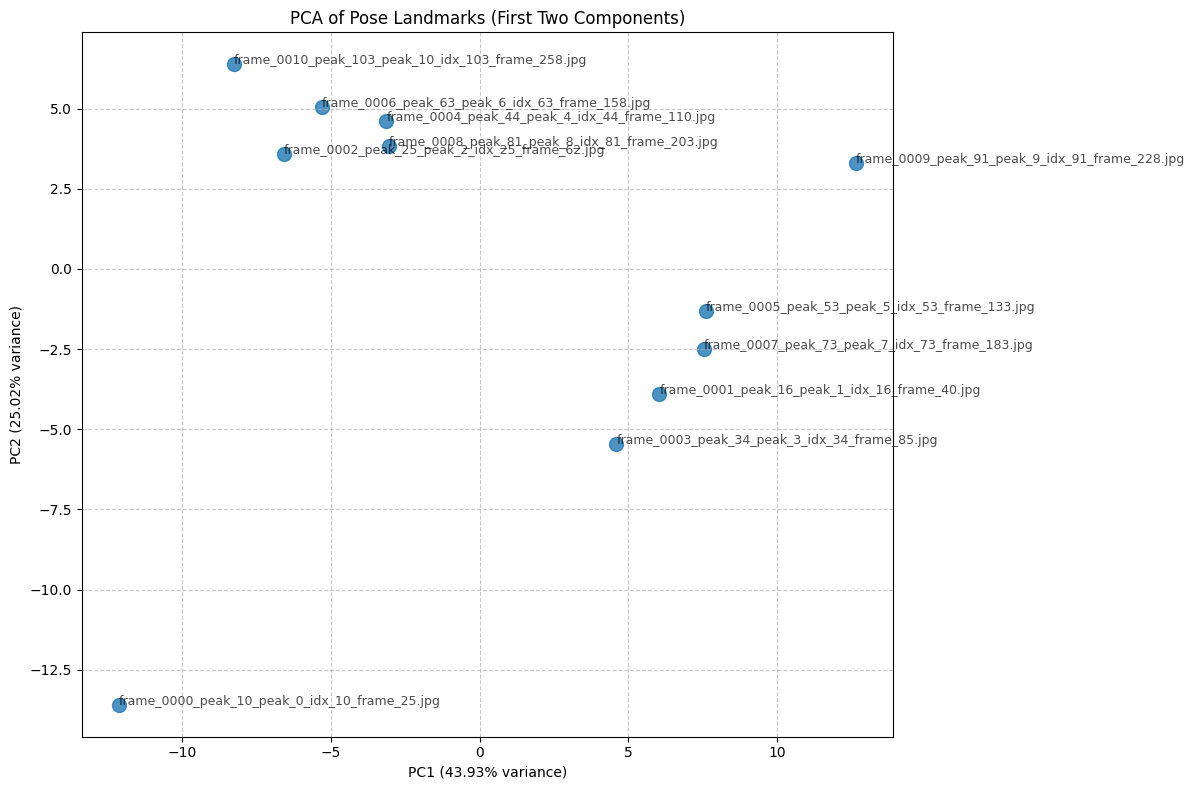

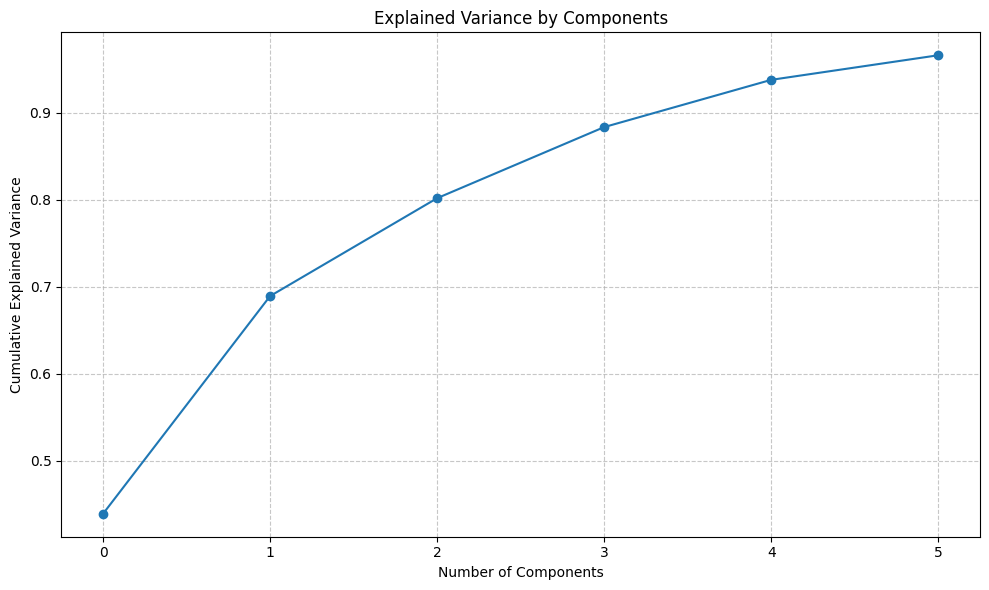

In [10]:
# PCA Analysis of Pose Landmark Vectors

# Load the pose dataframe if not already in memory
try:
    # Check if pose_df exists
    pose_df
    print("Using existing pose_df")
except NameError:
    # If not, try to load from pickle
    pickle_path = os.path.join('/home/is1893/Mirror2/pose-results', 'pose_landmarks_data.pkl')
    if os.path.exists(pickle_path):
        pose_df = pd.read_pickle(pickle_path)
        print(f"Loaded pose_df from {pickle_path}")
    else:
        # If pickle doesn't exist, try CSV
        csv_path = os.path.join('/home/is1893/Mirror2/pose-results', 'pose_landmarks_data.csv')
        if os.path.exists(csv_path):
            pose_df = pd.read_csv(csv_path)
            print(f"Loaded pose_df from {csv_path}")
        else:
            raise FileNotFoundError("Could not find pose_landmarks_data.pkl or pose_landmarks_data.csv")

# Extract only the landmark data (exclude image_name and processing_time)
landmark_columns = [col for col in pose_df.columns if col.startswith('landmark_')]
X_pose = pose_df[landmark_columns]

# Check for and handle any NaN values
if X_pose.isna().any().any():
    print(f"Found {X_pose.isna().sum().sum()} NaN values. Filling with zeros.")
    X_pose = X_pose.fillna(0)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_pose_scaled = scaler.fit_transform(X_pose)

# Apply PCA
from sklearn.decomposition import PCA
# Choose number of components - can keep 95% of variance or specific number
pca = PCA(n_components=.95)  # Keep components that explain 95% of variance
X_pose_pca = pca.fit_transform(X_pose_scaled)

# Print PCA results
print(f"Original data shape: {X_pose.shape}")
print(f"PCA data shape: {X_pose_pca.shape}")
print(f"Number of components selected: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(X_pose_pca, columns=[f'PC{i+1}' for i in range(X_pose_pca.shape[1])])
pca_df['image_name'] = pose_df['image_name']

# Display first few rows of PCA results
print("\nPCA Results (first few rows):")
pca_df.head()

# Visualize the first two principal components
plt.figure(figsize=(12, 8))
plt.scatter(X_pose_pca[:, 0], X_pose_pca[:, 1], alpha=0.8, s=100)

# Add image labels
for i, img in enumerate(pose_df['image_name']):
    plt.annotate(img, (X_pose_pca[i, 0], X_pose_pca[i, 1]), 
                 fontsize=9, alpha=0.7)

plt.title('PCA of Pose Landmarks (First Two Components)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Using PCA results with 6 components explaining 96.63% of variance
K=2, Silhouette Score: 0.3474
K=3, Silhouette Score: 0.3778
K=4, Silhouette Score: 0.3474
K=5, Silhouette Score: 0.3024
K=6, Silhouette Score: 0.3841
K=7, Silhouette Score: 0.3703
K=8, Silhouette Score: 0.3040
K=9, Silhouette Score: 0.2277
K=10, Silhouette Score: 0.1463


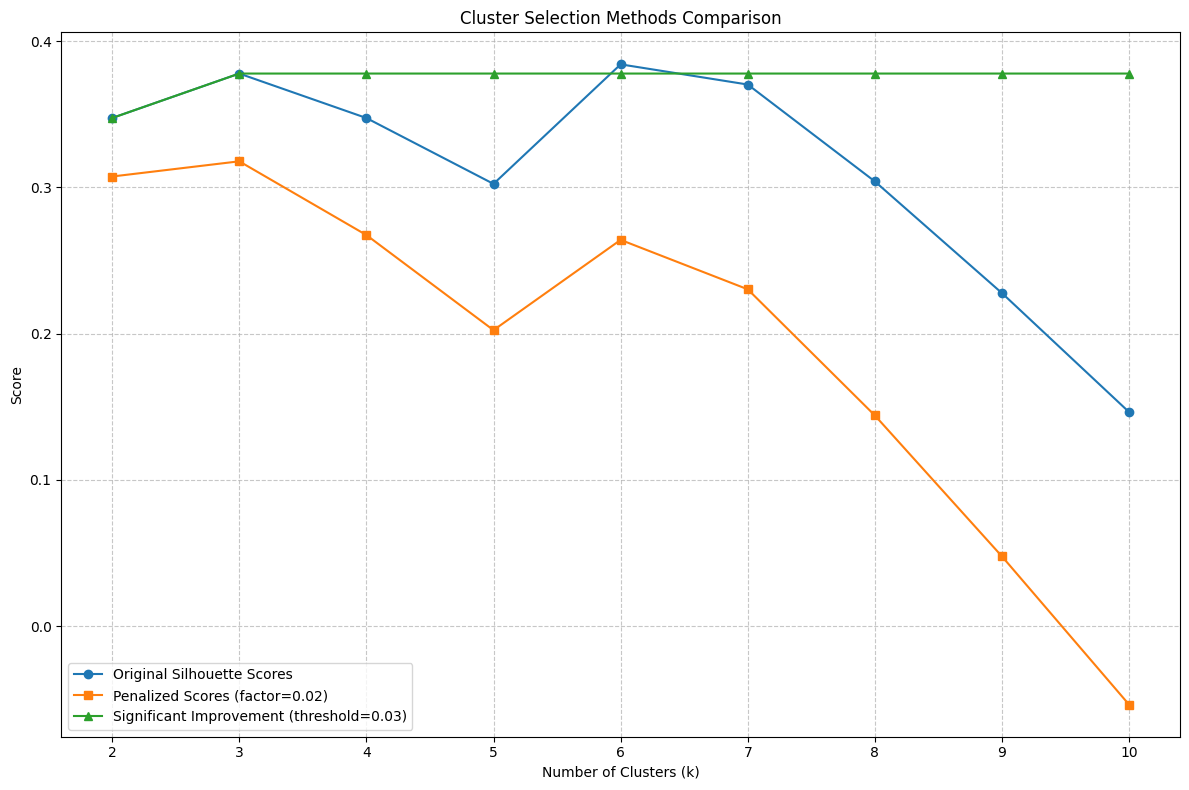

Best k (original silhouette): 6
Best k (with penalty factor): 3
Best k (significant improvement): 3

Using k=3 for final clustering


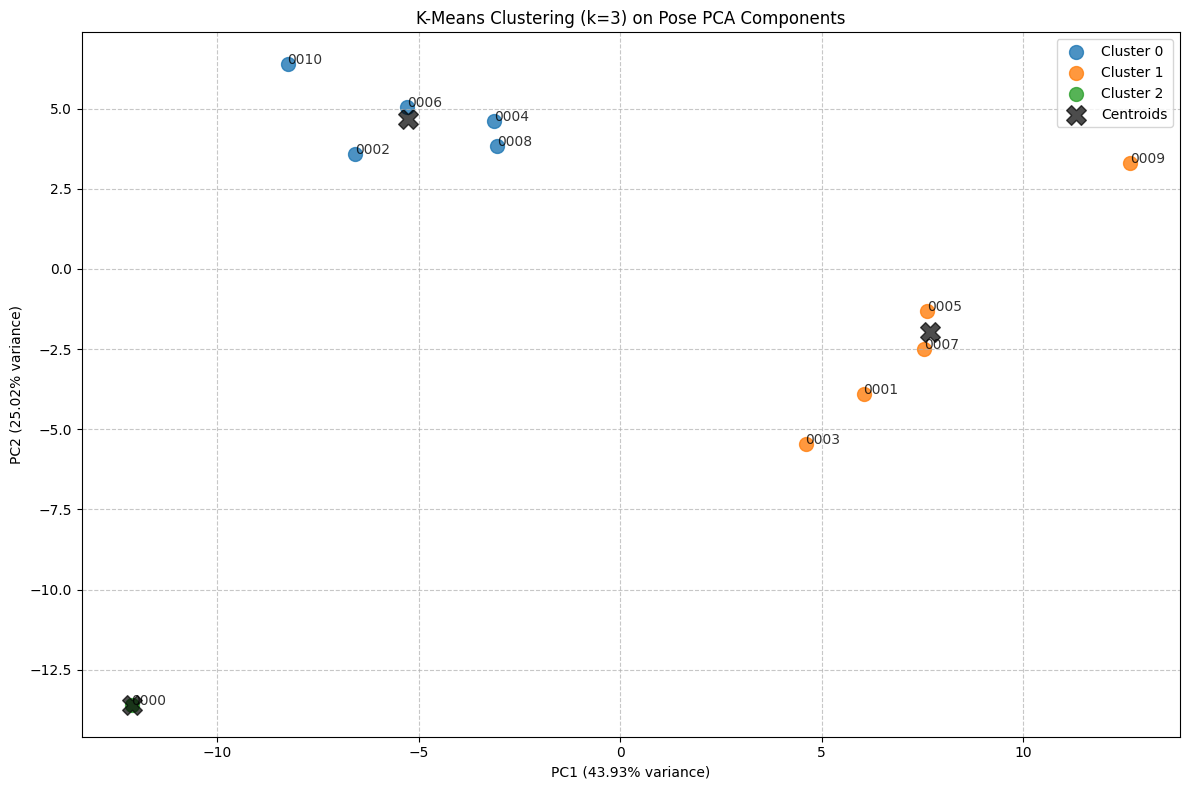


Clustering Results:


,image_name,cluster,PC1,PC2
2,frame_0002_peak_25_peak_2_idx_25_frame_62.jpg,0,-6.580678,3.581660
4,frame_0004_peak_44_peak_4_idx_44_frame_110.jpg,0,-3.125677,4.599326
6,frame_0006_peak_63_peak_6_idx_63_frame_158.jpg,0,-5.287950,5.048672
8,frame_0008_peak_81_peak_8_idx_81_frame_203.jpg,0,-3.056959,3.842110
10,frame_0010_peak_103_peak_10_idx_103_frame_258.jpg,0,-8.255644,6.378951
3,frame_0003_peak_34_peak_3_idx_34_frame_85.jpg,1,4.598637,-5.450401
5,frame_0005_peak_53_peak_5_idx_53_frame_133.jpg,1,7.607482,-1.297172
1,frame_0001_peak_16_peak_1_idx_16_frame_40.jpg,1,6.035126,-3.911292
9,frame_0009_peak_91_peak_9_idx_91_frame_228.jpg,1,12.648785,3.290265
7,frame_0007_peak_73_peak_7_idx_73_frame_183.jpg,1,7.541158,-2.492382


: 

In [ ]:
# Modified clustering approach that favors fewer clusters

# Use the PCA results we already have
print(f"Using PCA results with {X_pose_pca.shape[1]} components explaining {sum(pca.explained_variance_ratio_):.2%} of variance")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Try different k values
k_values = range(2, min(11, len(X_pose_pca)))
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pose_pca)
    
    # Calculate silhouette score
    if len(np.unique(labels)) > 1:  # Need at least 2 clusters for silhouette score
        score = silhouette_score(X_pose_pca, labels)
        silhouette_scores.append(score)
        print(f"K={k}, Silhouette Score: {score:.4f}")
    else:
        silhouette_scores.append(0)
        print(f"K={k}, Only one cluster found")

# Apply a penalty to favor smaller k values
# Method 1: Apply a penalty factor based on number of clusters
penalty_factor = 0.02  # Adjust this value to control how much to penalize larger cluster counts
penalized_scores = [score - (k * penalty_factor) for score, k in zip(silhouette_scores, k_values)]

# Method 2: Use the "elbow method" on silhouette scores
# Calculate differences between consecutive scores
score_diffs = np.diff(silhouette_scores)
# Prepend a 0 to make it the same length as k_values
score_diffs = np.insert(score_diffs, 0, 0)

# Method 3: Only choose a larger k if it improves the score by a significant margin
significant_improvement = 0.03  # Minimum improvement to justify more clusters
improved_scores = silhouette_scores.copy()
for i in range(1, len(improved_scores)):
    # Only keep the higher score if it's significantly better
    if improved_scores[i] - improved_scores[i-1] < significant_improvement:
        improved_scores[i] = improved_scores[i-1]

# Display results of all methods
plt.figure(figsize=(12, 8))
plt.plot(list(k_values), silhouette_scores, marker='o', label='Original Silhouette Scores')
plt.plot(list(k_values), penalized_scores, marker='s', label=f'Penalized Scores (factor={penalty_factor})')
plt.plot(list(k_values), improved_scores, marker='^', label=f'Significant Improvement (threshold={significant_improvement})')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.title('Cluster Selection Methods Comparison')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Get best k from each method
best_k_original = list(k_values)[np.argmax(silhouette_scores)]
best_k_penalized = list(k_values)[np.argmax(penalized_scores)]
best_k_improved = list(k_values)[np.argmax(improved_scores)]

print(f"Best k (original silhouette): {best_k_original}")
print(f"Best k (with penalty factor): {best_k_penalized}")
print(f"Best k (significant improvement): {best_k_improved}")

# Let's use the penalized method for our final clustering
best_k = best_k_penalized
print(f"\nUsing k={best_k} for final clustering")

# Apply K-means with best k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pose_pca)

# Add cluster labels to the PCA dataframe
pca_df['cluster'] = cluster_labels

# Visualize clusters using the first two PCA components
plt.figure(figsize=(12, 8))

# Plot each cluster with different color
for i in range(best_k):
    # Get points in this cluster
    cluster_points = X_pose_pca[cluster_labels == i]
    # Plot them
    plt.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        s=100, 
        alpha=0.8,
        label=f'Cluster {i}'
    )

# Add image labels
for i, img in enumerate(pose_df['image_name']):
    # Extract frame number from filename for cleaner labels
    frame_num = img.split('_')[1] if '_' in img else img
    plt.annotate(frame_num, (X_pose_pca[i, 0], X_pose_pca[i, 1]), 
                 fontsize=10, alpha=0.8)

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7, marker='X', label='Centroids')

plt.title(f'K-Means Clustering (k={best_k}) on Pose PCA Components')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Create a summary table of the clustering results
summary_df = pd.DataFrame({
    'image_name': pose_df['image_name'],
    'cluster': cluster_labels,
    'PC1': X_pose_pca[:, 0],
    'PC2': X_pose_pca[:, 1]
})

# Sort by cluster for better readability
summary_df = summary_df.sort_values('cluster')
print("\nClustering Results:")
summary_df